In [1]:
from fastai.vision.all import *
from fastai.learner import *
from fastai.data.all import *
from fastai.callback.tracker import SaveModelCallback
import pandas as pd
import matplotlib.pyplot as plt
from pathlib2 import Path
import numpy as np
import random
from torch.nn import MSELoss

You can download the ebooks [here](https://www.openslr.org/resources/12/original-books.tar.gz).

We will need the pretrained embeddings from https://github.com/iamyuanchung/speech2vec-pretrained-vectors. We will use them to compare our results and also to figure out what vocab the authors of the speech2vec paper used for training. Let us start with the latter.

In [2]:
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
tasks = {
    "MEN": fetch_MEN(),
    "WS353": fetch_WS353(),
    "SIMLEX999": fetch_SimLex999()
}

In [4]:
starting_lines = {
    '1004/1004.txt.utf-8': 535,
    '10123/10123.txt.utf-8': 85,
    '10359/10359.txt.utf-8': 76,
    '10360/10360.txt.utf-8': 57,
    '10378/10378.txt.utf-8': 96,
    '10390/10390.txt.utf-8': 89,
    '1193/1193.txt.utf-8': 272,
    '12441/12441-0.txt': 101,
    '1249/1249.txt.utf-8': 614,
    '1325/1325.txt.utf-8': 434,
    '1674/1674.txt.utf-8': 360,
    '2046/2046.txt.utf-8': 295,
    '2147/2147.txt.utf-8': 66,
    '2184/2184.txt.utf-8': 302,
    '2383/2383.txt.utf-8': 408,
    '2486/2486.txt.utf-8': 293,
    '2488/2488.txt.utf-8': 495,
    '2512/2512-0.txt': 113,
    '2515/2515.txt.utf-8': 281,
    '2678/2678.txt.utf-8': 305,
    '2679/2679.txt.utf-8': 308,
    '269/269-0.txt': 67,
    '282/282-0.txt': 43,
    '2891/2891.txt.utf-8': 336,
    '3053/3053.txt.utf-8': 340,
    '3169/3169.txt.utf-8': 386,
    '325/325.txt.utf-8': 170,
    '3300/3300.txt.utf-8': 40,
    '34757/34757-0.txt': 185,
    '3604/3604.txt.utf-8': 612,
    '3623/3623.txt.utf-8': 342,
    '3697/3697.txt.utf-8': 449,
    '37660/37660-0.txt': 74,
    '4028/4028.txt.utf-8': 402,
    '4042/4042.txt.utf-8': 438,
    '435/435.txt.utf-8': 62,
    '6456/6456.txt.utf-8': 53,
    '7098/7098.txt.utf-8': 77,
    '76/76.txt.utf-8': 579,
    '778/778.txt.utf-8': 297,
    '786/786-0.txt': 158,
}   

In [5]:
%%time

text = ''

for fn, starting_line in starting_lines.items():
    with open(f'data/books/LibriSpeech/books/utf-8/{fn}') as file:
        lines = file.readlines()[starting_line:]
        text += ' '.join(lines)

CPU times: user 76 ms, sys: 44 ms, total: 120 ms
Wall time: 120 ms


In [6]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp.tokenizer(text)

In [7]:
words = [token.text.lower() for token in doc if token.is_punct != True and str(token).isalpha()]

In [8]:
len(words)

3694374

In [9]:
c = Counter(words)
len(c)

60364

In [10]:
words[:20]

['midway',
 'upon',
 'the',
 'journey',
 'of',
 'our',
 'life',
 'i',
 'found',
 'myself',
 'within',
 'a',
 'forest',
 'dark',
 'for',
 'the',
 'straightforward',
 'pathway',
 'had',
 'been']

In [11]:
speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/speech2vec/50.vec', binary=False) 

In [12]:
speech2vec_vocab = set(speech2vec.vocab.keys())

# vocab = [w for w, c in c.most_common() if c > 25]
vocab = list(set(words))
vocab = [w for w in vocab if w in speech2vec_vocab]

In [13]:
len(vocab)

29876

In [14]:
len(words)

3694374

In [15]:
%%time

word_pairs = []
offsets = [-2, -1, 1, 2]
vocab_set = set(vocab)

for i, source_w in enumerate(words):
    if source_w not in vocab_set: continue
    for o in offsets:
        try:
            target_w = words[i+o]
        except: continue
        if target_w in vocab_set:
            word_pairs.append([source_w, target_w])

CPU times: user 13.9 s, sys: 608 ms, total: 14.5 s
Wall time: 14.5 s


In [16]:
len(word_pairs)

14129207

In [17]:
# np.random.shuffle(word_pairs)

In [ ]:
# from collections import Counter

# c = Counter(all_words)

# vocab = [w for w, count in c.most_common() if count >= 50]

# len(vocab)

In [ ]:
# from collections import Counter

# c = Counter([w0 for w0, w1 in word_pairs])

# missing = []
# for w, count in c.items():
#     if count < 25: missing.append(w)

# ', '.join([f'"{w}"' for w in missing])

In [72]:
vocab = set()
for w1, w2 in word_pairs:
    vocab.add(w1)

In [73]:
vocab = list(vocab)

In [38]:
word2index = {w: i for i, w in enumerate(vocab)}

In [39]:
from collections import defaultdict

In [40]:
class Dataset():
    def __init__(self, pairs, len_mult=1000):
        self.pairs = pairs
        self.len_mult = len_mult
        self.word2row_idxs = defaultdict(list)

        for idx, (source_word, target_word) in enumerate(pairs):
            self.word2row_idxs[source_word].append(idx)
    def __len__(self):
        return len(vocab) * self.len_mult
    def __getitem__(self, idx):
        word_idx = idx % len(vocab)
        word = vocab[word_idx]
        row_idx = np.random.choice(self.word2row_idxs[word])
        source_word, target_word = self.pairs[row_idx]
        return word2index[source_word], word2index[target_word]

In [43]:
train_ds = Dataset(word_pairs)
valid_ds = Dataset(word_pairs)

In [44]:
missing = []
for w, idxs in train_ds.word2row_idxs.items():
    if len(idxs) == 0: missing.append(w)
for w, idxs in  valid_ds.word2row_idxs.items():
    if len(idxs) == 0 : missing.append(w)

print(', '.join([f'"{w}"' for w in missing]))

for i in range(len(vocab)):
    train_ds[i]
    
for i in range(len(vocab)):
    valid_ds[i]

In [45]:
len(train_ds), len(valid_ds)

(29873000, 29873000)

In [46]:
BS = 2048
NUM_WORKERS = 8

train_dl = DataLoader(train_ds, BS, NUM_WORKERS, shuffle=True)
valid_dl = DataLoader(valid_ds, BS, NUM_WORKERS)

dls = DataLoaders(train_dl, valid_dl)

In [47]:
class Model(Module):
    def __init__(self, hidden_size=50):
        self.embeddings = nn.Embedding(len(vocab), hidden_size)
        self.linear = nn.Linear(hidden_size, len(vocab))
            
    def forward(self, x):
        x = self.embeddings(x)
        return self.linear(x)

In [48]:
learn = Learner(
    dls.cuda(),
    Model().cuda(),
    loss_func=CrossEntropyLossFlat(),
    opt_func=Adam,
    metrics=[accuracy]
)

In [49]:
NUM_EPOCHS = 20
learn.fit(NUM_EPOCHS, lr=1e-3, cbs=SaveModelCallback(fname='text_embeddings', every_epoch=True))

epoch,train_loss,valid_loss,accuracy,time
0,5.435266,5.448726,0.113236,18:08
1,4.914404,4.902357,0.132039,18:23
2,4.581921,4.579188,0.140887,17:48
3,4.400144,4.401237,0.144777,17:44
4,4.302540,4.299611,0.146375,18:24
5,4.248083,4.239969,0.146958,17:53
6,4.203971,4.201066,0.147572,17:45
7,4.170121,4.174359,0.147535,17:55
8,4.152227,4.154513,0.147813,18:16
9,4.137247,4.139415,0.147880,17:54


## Evalute embeddings

In [51]:
from utils import Embeddings

In [52]:
embeddings = learn.model.embeddings.weight.cpu().detach().numpy()

In [65]:
e = Embeddings(
    embeddings,
    vocab
)

In [66]:
for w in ['fast', 'lost', 'small', 'true', 'nice', 'slow']:
    print(f'{w}: {e.nn_words_to(e[w])}')

fast: ['fast', 'down', 'lay', 'looked', 'just']
lost: ['lost', 'yet', 'that', 'utterly', 'since']
small: ['small', 'large', 'fine', 'vast', 'travelling']
true: ['true', 'truth', 'that', 'indeed', 'best']
nice: ['nice', 'foolish', 'clever', 'hard', 'comfortable']
slow: ['slow', 'swift', 'moving', 'strong', 'sound']


## Evaluating embeddings using [word-embeddings-benchmarks](https://github.com/kudkudak/word-embeddings-benchmarks)

In [74]:
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [75]:
tasks = {
    "MEN": fetch_MEN(),
    "WS353": fetch_WS353(),
    "SIMLEX999": fetch_SimLex999()
}

In [76]:
our_embeddings = Embedding(
    Vocabulary(vocab),
    embeddings
)

speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/word2vec/50.vec', binary=False) 
speech2vec_embeddings = Embedding(Vocabulary(list(speech2vec.vocab.keys())), speech2vec.vectors)

In [77]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(our_embeddings, data.X, data.y)))

Missing 530 words. Will replace them with mean vector
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:336: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  A = np.vstack(w.get(word, mean_vector) for word in X[:, 0])
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  B = np.vstack(w.get(word, mean_vector) for word in X[:, 1])
Missing 75 words. Will replace them with mean vector
Missing 36 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.25316331304609385
Spearman correlation of scores on WS353 0.1194036009537742
Spearman correlation of scores on SIMLEX999 0.04217566566804081


In [78]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(speech2vec_embeddings, data.X, data.y)))

Missing 392 words. Will replace them with mean vector
Missing 61 words. Will replace them with mean vector
Missing 24 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.6056592803599269
Spearman correlation of scores on WS353 0.43349390636024643
Spearman correlation of scores on SIMLEX999 0.25938770901422736


## Loss decrease and improvements on semantic tasks as training progresses

In [79]:
%%capture

val_losses, accuracies, task_perf = [], [], []
for i in range(NUM_EPOCHS):
    learn.load(f'text_embeddings_{i}')
    loss, accuracy = learn.validate()
    val_losses.append(loss)
    accuracies.append(accuracy)
    
    embeddings = learn.model.embeddings.weight.cpu().detach().numpy()
    our_embeddings = Embedding(
        Vocabulary([w.lower() for w in vocab]),
        embeddings
    )

    task_perf.append([evaluate_similarity(our_embeddings, data.X, data.y) for name, data in iteritems(tasks)])

In [80]:
men, ws353, simlex999 = list(zip(*task_perf))

In [81]:
import matplotlib.pyplot as plt

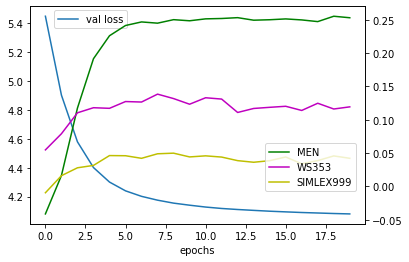

In [82]:
fig, ax1 = plt.subplots()

ax1.plot(val_losses, label='val loss')

ax2 = ax1.twinx()
ax2.plot(men, label='MEN', c='g')
ax2.plot(ws353, label='WS353', c='m')
ax2.plot(simlex999, label='SIMLEX999', c='y')

ax1.legend(loc=[0.07, 0.9])
ax2.legend(loc=[0.7, 0.15])

ax1.set_xlabel('epochs');